# Author
Quan Chen 470199228
Yujun He 480113210
Yuyang Hong 470083019

# Hardware and operation system information

Operation system: Ubuntu 18.0

CPU: i7-8700k

GPU: 1080 Ti

RAM: 16GB

SSD: 256GB



# Python environment

python 3.6.4

numpy 1.15.1

matplolib 2.2.2

h5py 2.7.1

sklearn 0.19.1 (only used to generate example data and evauation)

scipy 1.0.0

In [1]:
# Data pre-processing
import itertools
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.datasets.fashion_mnist import load_data
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,classification_report
from sklearn.preprocessing import label_binarize


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout,BatchNormalization

/home/quanchen/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#------------------------#
# Utility
#------------------------#
# def compute_precision_recall_F1(y_true, y_predict):
#     return round(precision_recall_fscore_support(y_true, y_predict, average='macro'), 3)


def compute_acc(y_true, y_predict):
    return round(accuracy_score(y_true, y_predict), 3)


def compute_cm(y_true, y_predict):
    return confusion_matrix(y_true, y_predict)


# Cited from matplotlib
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.get_cmap('Blues')):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



In [3]:
#------------------------#
# Data pre-processing
#------------------------#
def load_mnist():
    '''
    Load data from the tensorflow
    '''
    (x_train, y_train), (x_test, y_test) = load_data()
    return (x_train, y_train), (x_test, y_test)


# split_data
def split_data(x_train, y_train, part=0.8):
    '''
    Shuffle then data and then split the data accroding to the part parameters
    '''
    # shuffle the data
    order = np.argsort(np.random.random(y_train.shape[0]))
    x_train = x_train[order]
    y_train = y_train[order]

    # split data to train data and validation data
    num_total_train = len(x_train)
    split_index = int(num_total_train*part)

    # index data
    x_vali = x_train[split_index:]
    y_vali = y_train[split_index:]
    x_train = x_train[:split_index]
    y_train = y_train[:split_index]

    return x_train, y_train, x_vali, y_vali



# Flatten the image and do standard(Z-score normalization)
def flatten(x_train, x_vali, x_test):
    '''
    Note:
         Use the std and mean from the training data and implement
         it to the validation data and test data
    RETRUN:
        Flattened and standard(Z-score normalization) training data
        The features size is 3072
    '''
    x_train = x_train.reshape(len(x_train), 28*28)
    x_vali = x_vali.reshape(len(x_vali), 28*28)
    x_test = x_test.reshape(len(x_test), 28*28)
    return x_train, x_vali, x_test


def zeros_means_nor(x_train, x_vali, x_test):
    if len(x_train.shape)>2:
        x_train = x_train.reshape(len(x_train), 28*28)
        x_vali = x_vali.reshape(len(x_vali), 28*28)
        x_test = x_test.reshape(len(x_test), 28*28)
        std = np.std(x_train, keepdims=True)
        mean = np.mean(x_train, keepdims=True)
        x_train = (x_train-mean)/std
        x_vali = (x_vali-mean)/std
        x_test = (x_test-mean)/std
        
        return x_train.reshape(len(x_train), 28,28,1), x_vali.reshape(len(x_vali), 28,28,1), x_test.reshape(len(x_test), 28,28,1)
    else:
        std = np.std(x_train, keepdims=True)
        mean = np.mean(x_train, keepdims=True)
        x_train = (x_train-mean)/std
        x_vali = (x_vali-mean)/std
        x_test = (x_test-mean)/std
        return x_train, x_vali, x_test
        



# One-hot embedding
def one_hot_coding(y_train, y_vali, y_test):
    '''
    Encode label to one-hot catogory
    '''
    y_train = to_categorical(y_train, num_classes=10)
    y_vali = to_categorical(y_vali, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)
    return y_train, y_vali, y_test

# CNN model

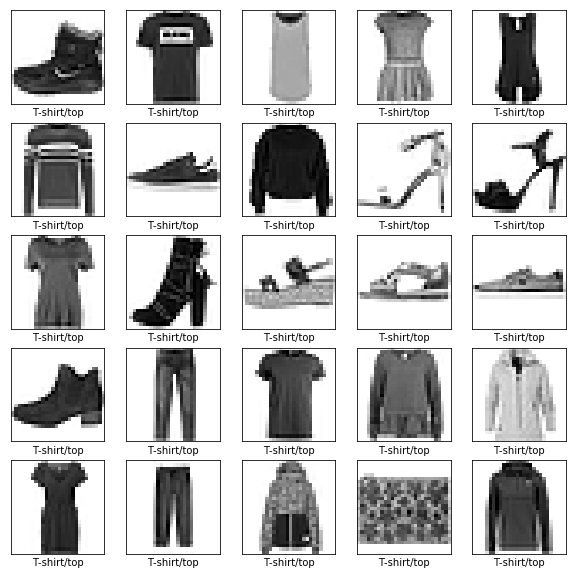

In [4]:
# load data and split data
(X_train, Y_train), (X_test, Y_test) = load_mnist()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(Y_train[i])])
    
# X_train = X_train.reshape(X_train.shape[0],784)
# X_test = X_test.reshape(X_test.shape[0],784)

# pca = PCA(n_components=625)
# pca.fit(X_train)

# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

# X_train = X_train.reshape(X_train.shape[0],25,25,1)
# X_test = X_test.reshape(X_test.shape[0],25,25,1)

In [5]:
#------------------------#
# CNN
#------------------------#

# Repeat 5 times
iteration = 10
epochs = 30
batch_size =512
traintimes = np.zeros(iteration)
testtimes = np.zeros(iteration)
accuracy  = np.zeros(iteration)

kf = KFold(n_splits=10)
 
for i,(train_index, test_index) in enumerate(kf.split(X_train)):
    x_train, x_vali = X_train[train_index], X_train[test_index]
    y_train, y_vali = Y_train[train_index], Y_train[test_index]

    x_train, y_train, x_vali, y_vali = split_data(X_train, Y_train, part=0.8)
    
    x_train, x_vali, x_test = zeros_means_nor(x_train, x_vali, X_test)
    
#     x_train = np.expand_dims(x_train,axis=3)
#     x_vali = np.expand_dims(x_vali,axis=3)
#     x_test = np.expand_dims(X_test,axis=3)

    y_train, y_vali, y_test = one_hot_coding(y_train, y_vali, Y_test)

    model = Sequential([
        Conv2D(128, (2, 2), use_bias=True, padding='same', activation='relu',input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (2, 2), use_bias=True, padding='same', activation='relu'),
        Conv2D(32, (2, 2), use_bias=True, padding='same', activation='relu'),
        Conv2D(32, (2, 2), use_bias=True, padding='same', activation='relu'),
        Conv2D(32, (2, 2), use_bias=True, padding='same', activation='relu'),
        Flatten(),
        BatchNormalization(momentum=0.99, epsilon=0.001),
        Dense(2000, activation='relu', use_bias=True),
        Dropout(0.5),
        Dense(1024, activation='relu', use_bias=True),
        Dense(10, activation=tf.nn.softmax)
    ])

    datagen = ImageDataGenerator(rotation_range=1.0, width_shift_range=0.05, height_shift_range=0.05)
    # datagen = ImageDataGenerator(featurewise_std_normalization=False)

    datagen.fit(x_train)
    adm = optimizers.Adam(lr=0.0002, decay=0.0001)
    model.compile(loss='categorical_crossentropy',
          optimizer=adm,
          metrics=['accuracy'])
    
    starttime = time()
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(x_train) / batch_size, epochs=epochs, validation_data=(x_vali, y_vali))
    traintimes[i] = time()-starttime
    print('CNN Model trained in {}s'.format(round(time()-starttime,2)))
     
    starttime = time()
    accuracy[i] = model.evaluate(x_test,y_test)[1]
    testtimes[i] = time()-starttime
    print('CNN Model predict in {}s'.format(round(time()-starttime,2)))

print('The average Trainng is {} $\pm$ {}s \nTesting time is {} $\pm$ {}s \nAccuracy is {} $\pm$ {}'.format(
    round(np.mean(traintimes),2), round(np.std(traintimes),2), 
    round(np.mean(testtimes),2), round(np.std(testtimes),2), 
    round(np.mean(accuracy),2), round(np.std(accuracy),3)))

Epoch 1/30
94/93 [==============================] - 8s 80ms/step - loss: 0.6050 - acc: 0.7773 - val_loss: 1.8132 - val_acc: 0.7972
Epoch 2/30
94/93 [==============================] - 5s 56ms/step - loss: 0.3862 - acc: 0.8565 - val_loss: 1.5110 - val_acc: 0.8599
Epoch 3/30
94/93 [==============================] - 5s 57ms/step - loss: 0.3360 - acc: 0.8775 - val_loss: 1.1303 - val_acc: 0.8971
Epoch 4/30
94/93 [==============================] - 5s 58ms/step - loss: 0.3006 - acc: 0.8901 - val_loss: 0.6759 - val_acc: 0.9068
Epoch 5/30
94/93 [==============================] - 5s 58ms/step - loss: 0.2807 - acc: 0.8963 - val_loss: 0.4347 - val_acc: 0.9069
Epoch 6/30
94/93 [==============================] - 5s 58ms/step - loss: 0.2617 - acc: 0.9028 - val_loss: 0.2837 - val_acc: 0.9122
Epoch 7/30
94/93 [==============================] - 5s 57ms/step - loss: 0.2474 - acc: 0.9081 - val_loss: 0.3076 - val_acc: 0.8827
Epoch 8/30
94/93 [==============================] - 5s 57ms/step - loss: 0.2383 - a

94/93 [==============================] - 7s 73ms/step - loss: 0.5935 - acc: 0.7802 - val_loss: 1.8512 - val_acc: 0.8360
Epoch 2/30
94/93 [==============================] - 5s 57ms/step - loss: 0.3704 - acc: 0.8630 - val_loss: 1.5413 - val_acc: 0.8785
Epoch 3/30
94/93 [==============================] - 6s 59ms/step - loss: 0.3215 - acc: 0.8819 - val_loss: 1.1021 - val_acc: 0.8997
Epoch 4/30
94/93 [==============================] - 5s 57ms/step - loss: 0.2996 - acc: 0.8896 - val_loss: 0.7462 - val_acc: 0.9016
Epoch 5/30
94/93 [==============================] - 5s 57ms/step - loss: 0.2721 - acc: 0.9002 - val_loss: 0.4269 - val_acc: 0.9100
Epoch 6/30
94/93 [==============================] - 5s 57ms/step - loss: 0.2598 - acc: 0.9038 - val_loss: 0.3208 - val_acc: 0.9052
Epoch 7/30
94/93 [==============================] - 5s 58ms/step - loss: 0.2468 - acc: 0.9093 - val_loss: 0.2360 - val_acc: 0.9142
Epoch 8/30
94/93 [==============================] - 5s 58ms/step - loss: 0.2311 - acc: 0.9143 

94/93 [==============================] - 7s 74ms/step - loss: 0.5800 - acc: 0.7881 - val_loss: 1.8626 - val_acc: 0.8359
Epoch 2/30
94/93 [==============================] - 5s 58ms/step - loss: 0.3823 - acc: 0.8584 - val_loss: 1.6044 - val_acc: 0.8796
Epoch 3/30
94/93 [==============================] - 5s 57ms/step - loss: 0.3302 - acc: 0.8778 - val_loss: 1.1873 - val_acc: 0.8877
Epoch 4/30
94/93 [==============================] - 5s 58ms/step - loss: 0.2997 - acc: 0.8886 - val_loss: 0.7596 - val_acc: 0.9048
Epoch 5/30
94/93 [==============================] - 5s 58ms/step - loss: 0.2755 - acc: 0.9000 - val_loss: 0.4797 - val_acc: 0.8982
Epoch 6/30
94/93 [==============================] - 5s 57ms/step - loss: 0.2600 - acc: 0.9043 - val_loss: 0.2971 - val_acc: 0.9133
Epoch 7/30
94/93 [==============================] - 5s 57ms/step - loss: 0.2474 - acc: 0.9078 - val_loss: 0.2520 - val_acc: 0.9152
Epoch 8/30
94/93 [==============================] - 5s 57ms/step - loss: 0.2358 - acc: 0.9122 

94/93 [==============================] - 7s 76ms/step - loss: 0.5901 - acc: 0.7824 - val_loss: 1.8264 - val_acc: 0.8333
Epoch 2/30
94/93 [==============================] - 5s 56ms/step - loss: 0.3821 - acc: 0.8579 - val_loss: 1.5055 - val_acc: 0.8826
Epoch 3/30
94/93 [==============================] - 5s 58ms/step - loss: 0.3306 - acc: 0.8773 - val_loss: 1.1828 - val_acc: 0.8832
Epoch 4/30
94/93 [==============================] - 5s 58ms/step - loss: 0.3024 - acc: 0.8873 - val_loss: 0.7455 - val_acc: 0.9013
Epoch 5/30
94/93 [==============================] - 5s 58ms/step - loss: 0.2826 - acc: 0.8949 - val_loss: 0.4268 - val_acc: 0.9092
Epoch 6/30
94/93 [==============================] - 5s 57ms/step - loss: 0.2640 - acc: 0.9014 - val_loss: 0.2838 - val_acc: 0.9122
Epoch 7/30
94/93 [==============================] - 5s 57ms/step - loss: 0.2467 - acc: 0.9093 - val_loss: 0.2466 - val_acc: 0.9116
Epoch 8/30
94/93 [==============================] - 5s 57ms/step - loss: 0.2368 - acc: 0.9115 

94/93 [==============================] - 7s 76ms/step - loss: 0.5697 - acc: 0.7922 - val_loss: 1.8378 - val_acc: 0.8408
Epoch 2/30
94/93 [==============================] - 5s 57ms/step - loss: 0.3701 - acc: 0.8631 - val_loss: 1.4790 - val_acc: 0.8861
Epoch 3/30
94/93 [==============================] - 5s 58ms/step - loss: 0.3229 - acc: 0.8796 - val_loss: 1.1572 - val_acc: 0.8949
Epoch 4/30
94/93 [==============================] - 5s 57ms/step - loss: 0.3010 - acc: 0.8894 - val_loss: 0.7973 - val_acc: 0.8866
Epoch 5/30
94/93 [==============================] - 5s 58ms/step - loss: 0.2723 - acc: 0.8991 - val_loss: 0.4351 - val_acc: 0.9053
Epoch 6/30
94/93 [==============================] - 5s 57ms/step - loss: 0.2567 - acc: 0.9037 - val_loss: 0.2910 - val_acc: 0.9110
Epoch 7/30
94/93 [==============================] - 5s 57ms/step - loss: 0.2431 - acc: 0.9103 - val_loss: 0.2507 - val_acc: 0.9113
Epoch 8/30
94/93 [==============================] - 6s 59ms/step - loss: 0.2342 - acc: 0.9135 

Normalized confusion matrix
[[0.828 0.    0.015 0.022 0.002 0.    0.127 0.    0.006 0.   ]
 [0.    0.981 0.001 0.009 0.005 0.    0.002 0.    0.002 0.   ]
 [0.014 0.    0.901 0.008 0.029 0.    0.048 0.    0.    0.   ]
 [0.004 0.001 0.004 0.946 0.014 0.    0.028 0.    0.003 0.   ]
 [0.    0.    0.047 0.018 0.885 0.    0.05  0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.993 0.    0.007 0.    0.   ]
 [0.06  0.    0.047 0.023 0.056 0.    0.812 0.    0.002 0.   ]
 [0.    0.    0.    0.    0.    0.009 0.    0.98  0.    0.011]
 [0.002 0.    0.002 0.005 0.001 0.002 0.003 0.002 0.983 0.   ]
 [0.    0.    0.    0.    0.    0.008 0.    0.027 0.    0.965]]
             precision    recall  f1-score   support

T-shirt/top       0.91      0.83      0.87      1000
    Trouser       1.00      0.98      0.99      1000
   Pullover       0.89      0.90      0.89      1000
      Dress       0.92      0.95      0.93      1000
       Coat       0.89      0.89      0.89      1000
     Sandal       0.98

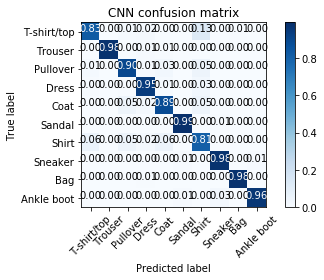

In [6]:
prediction = model.predict(x_test)
cm = compute_cm(Y_test, np.argmax(prediction,axis=1))
plot_confusion_matrix(cm, class_names,
                          normalize=True,
                          title='CNN confusion matrix',
                          cmap=plt.get_cmap('Blues'))

print(classification_report(np.argmax(y_test,axis=1), np.argmax(prediction,axis=1), target_names=class_names))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 28, 28, 128)       640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 14, 14, 64)        32832     
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 14, 14, 32)        8224      
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 14, 14, 32)        4128      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 14, 14, 32)        4128      
_________________________________________________________________
flatten_9 (Flatten)          (None, 6272)              0         
__________

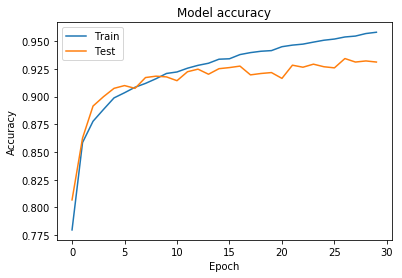

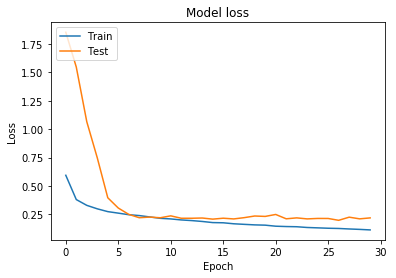

In [8]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Lightgbm 

In [9]:
# load data and split data
(X_train, Y_train), (X_test, Y_test) = load_mnist()
X_train = X_train.reshape(X_train.shape[0],784)
X_test = X_test.reshape(X_test.shape[0],784)

Y_train = Y_train.flatten()
Y_test = Y_test.flatten()


# pca = PCA(n_components=600)
# pca.fit(X_train)

# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)


params = {
    'task': 'train',
    'learning_rate':0.2,
    'num_leaves': 200,
    'min_data_in_leaf':300,
    'num_iterations':60, #60
    'objective': 'multiclass',
    'num_class':10,
    'metric': {'multi_logloss'},
    'num_threads':4,

}

# Repeat 5 times
iteration = 10
traintimes = np.zeros(iteration)
testtimes = np.zeros(iteration)
valiaccuracy  = np.zeros(iteration)
testaccuracy  = np.zeros(iteration)


kf = KFold(n_splits=10)
 
for i,(train_index, test_index) in enumerate(kf.split(X_train)):
    x_train, x_vali = X_train[train_index], X_train[test_index]
    y_train, y_vali = Y_train[train_index], Y_train[test_index]

    x_train, x_vali, x_test = zeros_means_nor(x_train, x_vali, X_test)

    train_data = lgb.Dataset(x_train, label=y_train)
    valid_sets = lgb.Dataset(x_vali, label=y_vali)
    
    starttime = time()
    model = lgb.train(params, train_data, valid_sets= valid_sets)
    traintimes[i] = time()-starttime
    
    starttime = time()
    y_pred = model.predict(x_test, num_iteration=model.best_iteration)
    testtimes[i] = time()-starttime
    
    vali_pred = model.predict(x_vali, num_iteration=model.best_iteration)
    testaccuracy[i] = accuracy_score(Y_test,np.argmax(y_pred,axis=1))
    valiaccuracy[i] = accuracy_score(y_vali,np.argmax(vali_pred,axis=1))
print('The average Trainng is {} $\pm$ {}s \nTesting time is {} $\pm$ {}s\nvaliAccuracy is {} $\pm$ {} \nTestAccuracy is {} $\pm$ {}'.format(
    round(np.mean(traintimes),2), round(np.std(traintimes),2), 
    round(np.mean(testtimes),2), round(np.std(testtimes),6), 
    round(np.mean(valiaccuracy),4), round(np.std(valiaccuracy),7), 
    round(np.mean(testaccuracy),4), round(np.std(testaccuracy),7)))   

/home/quanchen/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.69292
[2]	valid_0's multi_logloss: 1.40192
[3]	valid_0's multi_logloss: 1.20312
[4]	valid_0's multi_logloss: 1.05405
[5]	valid_0's multi_logloss: 0.936792
[6]	valid_0's multi_logloss: 0.843781
[7]	valid_0's multi_logloss: 0.765119
[8]	valid_0's multi_logloss: 0.701079
[9]	valid_0's multi_logloss: 0.646523
[10]	valid_0's multi_logloss: 0.599881
[11]	valid_0's multi_logloss: 0.560939
[12]	valid_0's multi_logloss: 0.527036
[13]	valid_0's multi_logloss: 0.498043
[14]	valid_0's multi_logloss: 0.473193
[15]	valid_0's multi_logloss: 0.450556
[16]	valid_0's multi_logloss: 0.43267
[17]	valid_0's multi_logloss: 0.415922
[18]	valid_0's multi_logloss: 0.400912
[19]	valid_0's multi_logloss: 0.387974
[20]	valid_0's multi_logloss: 0.377149
[21]	valid_0's multi_logloss: 0.367642
[22]	valid_0's multi_logloss: 0.358384
[23]	valid_0's multi_logloss: 0.349617
[24]	valid_0's multi_logloss: 0.341876
[25]	valid_0's multi_logloss: 0.33523
[26]	valid_0's multi_logloss: 0.328977
[

[33]	valid_0's multi_logloss: 0.304057
[34]	valid_0's multi_logloss: 0.30148
[35]	valid_0's multi_logloss: 0.298691
[36]	valid_0's multi_logloss: 0.29595
[37]	valid_0's multi_logloss: 0.293563
[38]	valid_0's multi_logloss: 0.29134
[39]	valid_0's multi_logloss: 0.29
[40]	valid_0's multi_logloss: 0.288205
[41]	valid_0's multi_logloss: 0.286288
[42]	valid_0's multi_logloss: 0.285043
[43]	valid_0's multi_logloss: 0.283006
[44]	valid_0's multi_logloss: 0.281729
[45]	valid_0's multi_logloss: 0.280206
[46]	valid_0's multi_logloss: 0.278765
[47]	valid_0's multi_logloss: 0.277335
[48]	valid_0's multi_logloss: 0.276241
[49]	valid_0's multi_logloss: 0.27496
[50]	valid_0's multi_logloss: 0.273914
[51]	valid_0's multi_logloss: 0.272551
[52]	valid_0's multi_logloss: 0.271596
[53]	valid_0's multi_logloss: 0.270903
[54]	valid_0's multi_logloss: 0.270079
[55]	valid_0's multi_logloss: 0.269775
[56]	valid_0's multi_logloss: 0.268902
[57]	valid_0's multi_logloss: 0.268128
[58]	valid_0's multi_logloss: 0.2

[6]	valid_0's multi_logloss: 0.840688
[7]	valid_0's multi_logloss: 0.763957
[8]	valid_0's multi_logloss: 0.700565
[9]	valid_0's multi_logloss: 0.645993
[10]	valid_0's multi_logloss: 0.599831
[11]	valid_0's multi_logloss: 0.560555
[12]	valid_0's multi_logloss: 0.527508
[13]	valid_0's multi_logloss: 0.4987
[14]	valid_0's multi_logloss: 0.474188
[15]	valid_0's multi_logloss: 0.452805
[16]	valid_0's multi_logloss: 0.434402
[17]	valid_0's multi_logloss: 0.418374
[18]	valid_0's multi_logloss: 0.404056
[19]	valid_0's multi_logloss: 0.391301
[20]	valid_0's multi_logloss: 0.380108
[21]	valid_0's multi_logloss: 0.369696
[22]	valid_0's multi_logloss: 0.360298
[23]	valid_0's multi_logloss: 0.352102
[24]	valid_0's multi_logloss: 0.345137
[25]	valid_0's multi_logloss: 0.33791
[26]	valid_0's multi_logloss: 0.331877
[27]	valid_0's multi_logloss: 0.325621
[28]	valid_0's multi_logloss: 0.320388
[29]	valid_0's multi_logloss: 0.315794
[30]	valid_0's multi_logloss: 0.311375
[31]	valid_0's multi_logloss: 0.

In [10]:
(X_train, Y_train), (X_test, Y_test) = load_mnist()
X_train = X_train.reshape(X_train.shape[0],784)
X_test = X_test.reshape(X_test.shape[0],784)

Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

kf = KFold(n_splits=10)

for i,(train_index, test_index) in enumerate(kf.split(X_train)):
    x_train, x_vali = X_train[train_index], X_train[test_index]
    y_train, y_vali = Y_train[train_index], Y_train[test_index]
    print(i,x_train.shape,x_vali.shape)


0 (54000, 784) (6000, 784)
1 (54000, 784) (6000, 784)
2 (54000, 784) (6000, 784)
3 (54000, 784) (6000, 784)
4 (54000, 784) (6000, 784)
5 (54000, 784) (6000, 784)
6 (54000, 784) (6000, 784)
7 (54000, 784) (6000, 784)
8 (54000, 784) (6000, 784)
9 (54000, 784) (6000, 784)


Normalized confusion matrix
[[0.855 0.    0.016 0.022 0.007 0.001 0.092 0.    0.007 0.   ]
 [0.001 0.972 0.001 0.016 0.005 0.    0.003 0.    0.002 0.   ]
 [0.013 0.    0.836 0.006 0.079 0.    0.063 0.    0.003 0.   ]
 [0.019 0.005 0.011 0.904 0.028 0.    0.03  0.    0.002 0.001]
 [0.001 0.    0.076 0.031 0.83  0.    0.062 0.    0.    0.   ]
 [0.    0.    0.    0.001 0.    0.97  0.    0.019 0.    0.01 ]
 [0.135 0.    0.095 0.025 0.069 0.    0.661 0.    0.015 0.   ]
 [0.    0.    0.    0.    0.    0.012 0.    0.966 0.    0.022]
 [0.002 0.002 0.004 0.003 0.002 0.001 0.008 0.005 0.973 0.   ]
 [0.    0.    0.    0.    0.    0.005 0.001 0.037 0.002 0.955]]
             precision    recall  f1-score   support

T-shirt/top       0.83      0.85      0.84      1000
    Trouser       0.99      0.97      0.98      1000
   Pullover       0.80      0.84      0.82      1000
      Dress       0.90      0.90      0.90      1000
       Coat       0.81      0.83      0.82      1000
     Sandal       0.98

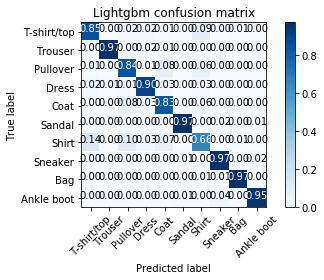

In [11]:
cm = compute_cm(Y_test, np.argmax(y_pred,axis=1))
plot_confusion_matrix(cm, class_names,
                          normalize=True,
                          title='Lightgbm confusion matrix',
                          cmap=plt.get_cmap('Blues'))

print(classification_report(Y_test, np.argmax(y_pred,axis=1), target_names=class_names))

# Random forest

In [14]:
# load data and split data
(X_train, Y_train), (X_test, Y_test) = load_mnist()
X_train = X_train.reshape(X_train.shape[0],784)
X_test = X_test.reshape(X_test.shape[0],784)

Y_train = Y_train.flatten()
Y_test = Y_test.flatten()



# pca = PCA(n_components=600)
# pca.fit(X_train)

# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)



# Repeat 5 times
iteration = 10
traintimes = np.zeros(iteration)
testtimes = np.zeros(iteration)
testaccuracy  = np.zeros(iteration)
valiaccuracy  = np.zeros(iteration)
kf = KFold(n_splits=10)
 
for i,(train_index, test_index) in enumerate(kf.split(X_train)):
    x_train, x_vali = X_train[train_index], X_train[test_index]
    y_train, y_vali = Y_train[train_index], Y_train[test_index]
    x_train, x_vali, x_test = zeros_means_nor(x_train, x_vali, X_test)
    clf = RandomForestClassifier(n_estimators=80, max_depth=80,min_samples_split=200)#80,80,200
    
    starttime = time()
    clf.fit(x_train,y_train)
    traintimes[i] = time()-starttime
    
    starttime = time()
    prediction = clf.predict(x_test)
    testtimes[i] = time()-starttime
    
    vali_pred = clf.predict(x_vali)
    
    testaccuracy[i] = accuracy_score(Y_test,prediction)
    
    valiaccuracy[i] = accuracy_score(y_vali,vali_pred)
    
print('The average Trainng is {} $\pm$ {}s \nTesting time is {} $\pm$ {}s\nvaliAccuracy is {} $\pm$ {} \nTestAccuracy is {} $\pm$ {}'.format(
    round(np.mean(traintimes),2), round(np.std(traintimes),2), 
    round(np.mean(testtimes),2), round(np.std(testtimes),6), 
    round(np.mean(valiaccuracy),4), round(np.std(valiaccuracy),7), 
    round(np.mean(testaccuracy),4), round(np.std(testaccuracy),7))) 

The average Trainng is 28.44 $\pm$ 0.28s 
Testing time is 0.17 $\pm$ 0.001311s
valiAccuracy is 0.8556 $\pm$ 0.0042712 
TestAccuracy is 0.8447 $\pm$ 0.0013676


Normalized confusion matrix
[[0.823 0.002 0.014 0.054 0.005 0.001 0.081 0.    0.02  0.   ]
 [0.003 0.939 0.009 0.037 0.004 0.    0.006 0.    0.002 0.   ]
 [0.009 0.    0.754 0.009 0.165 0.    0.051 0.    0.012 0.   ]
 [0.021 0.003 0.013 0.891 0.034 0.    0.03  0.    0.007 0.001]
 [0.    0.003 0.103 0.043 0.798 0.    0.049 0.    0.004 0.   ]
 [0.    0.    0.    0.001 0.    0.941 0.    0.043 0.003 0.012]
 [0.182 0.002 0.142 0.04  0.109 0.001 0.493 0.    0.031 0.   ]
 [0.    0.    0.    0.    0.    0.023 0.    0.907 0.001 0.069]
 [0.    0.001 0.011 0.005 0.006 0.003 0.007 0.004 0.962 0.001]
 [0.    0.    0.    0.    0.    0.013 0.001 0.047 0.003 0.936]]
             precision    recall  f1-score   support

T-shirt/top       0.79      0.82      0.81      1000
    Trouser       0.99      0.94      0.96      1000
   Pullover       0.72      0.75      0.74      1000
      Dress       0.82      0.89      0.86      1000
       Coat       0.71      0.80      0.75      1000
     Sandal       0.96

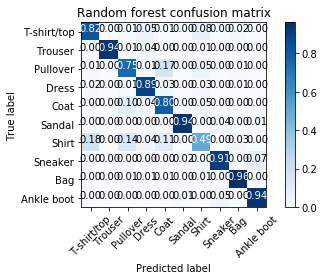

In [15]:
cm = compute_cm(Y_test, prediction)
plot_confusion_matrix(cm, class_names,
                          normalize=True,
                          title='Random forest confusion matrix',
                          cmap=plt.get_cmap('Blues'))
print(classification_report(Y_test, prediction, target_names=class_names))